## Example of quantitative metrics

In [ ]:
import os
#virtually move to parent directory
os.chdir("..")

import torch
import pandas as pd

import clip
import utils
import data_utils
import similarity

from matplotlib import pyplot as plt
from sentence_transformers import SentenceTransformer

## Settings

In [2]:
#change concept set to get different rows of Figure 3
concept_set = 'data/imagenet_labels.txt' #'data/20k.txt'
d_probe = 'imagenet_broden'

clip_name = 'ViT-B/16'
target_name = 'resnet50'
target_layer = 'fc'
batch_size = 200
device = 'cuda'
pool_mode = 'avg'

save_dir = 'saved_activations'
similarity_fn = similarity.soft_wpmi

## Run CLIP-Dissect

In [3]:
utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = [target_layer], 
                       d_probe = d_probe, concept_set = concept_set, batch_size = batch_size, 
                       device = device, pool_mode=pool_mode, save_dir = save_dir)

In [4]:
save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                  target_layer = target_layer, d_probe = d_probe,
                                  concept_set = concept_set, pool_mode=pool_mode,
                                  save_dir = save_dir)

target_save_name, clip_save_name, text_save_name = save_names

similarities, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name, 
                                                    text_save_name, similarity_fn, device=device)

with open(concept_set, 'r') as f: 
    words = (f.read()).split('\n')

100%|██████████| 1000/1000 [00:01<00:00, 676.39it/s]

torch.Size([1000, 1000])


In [5]:
model = SentenceTransformer('all-mpnet-base-v2')
clip_model, _ = clip.load(clip_name, device=device)

with open('data/imagenet_labels.txt', 'r') as f: 
    imagenet_classnames = (f.read()).split('\n')

## Collect results of all 3 models

In [6]:
clip_preds = torch.argmax(similarities, dim=1)
clip_preds = [words[int(pred)] for pred in clip_preds]

In [7]:
netdissect_res = pd.read_csv('data/NetDissect_results/resnet50_imagenet_fc.csv')
nd_preds = netdissect_res['label'].values

In [8]:
milan_preds = pd.read_csv('data/MILAN_results/m_base_resnet50_imagenet.csv')
milan_preds = milan_preds[milan_preds['layer']=='fc']
milan_preds = milan_preds.sort_values(by=['unit'])
milan_preds = list(milan_preds['description'])

# Figure 3


 Layer:fc Neuron:150, Gt:sea lion
Network Dissection: coast-s 0.7754 0.3473
MILAN: Animals in the water 0.8047 0.3291
CLIP-Dissect: sea lion 1.0010 1.0000


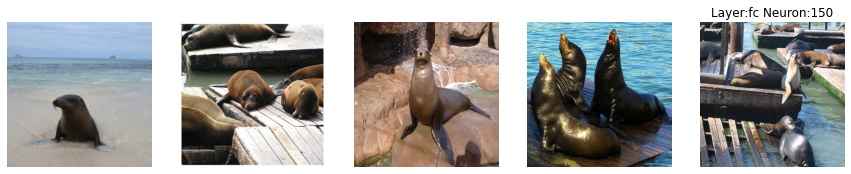

In [9]:
#most activating images for each neuron
top_vals, top_ids = torch.topk(target_feats, k=5, dim=0)

pil_data = data_utils.get_data(d_probe)

ids_to_check = [150]

for orig_id in ids_to_check:#range(20):
    orig_id = int(orig_id)
    #print(mse)
    print('\n Layer:{} Neuron:{}, Gt:{}'.format(target_layer, orig_id, imagenet_classnames[orig_id]))
    
    clip_cos, mpnet_cos = utils.get_cos_similarity(nd_preds[orig_id:orig_id+1], 
                                                   imagenet_classnames[orig_id:orig_id+1], 
                                                   clip_model, model, device, batch_size)
    print('Network Dissection: {} {:.4f} {:.4f}'.format(nd_preds[orig_id], clip_cos, mpnet_cos))
    
    clip_cos, mpnet_cos = utils.get_cos_similarity(milan_preds[orig_id:orig_id+1], 
                                                   imagenet_classnames[orig_id:orig_id+1],
                                                   clip_model, model, device, batch_size)
    print('MILAN: {} {:.4f} {:.4f}'.format(milan_preds[orig_id], clip_cos, mpnet_cos))
    
    clip_cos, mpnet_cos = utils.get_cos_similarity(clip_preds[orig_id:orig_id+1], 
                                                   imagenet_classnames[orig_id:orig_id+1],
                                                   clip_model, model, device, batch_size)
    print('CLIP-Dissect: {} {:.4f} {:.4f}'.format(clip_preds[orig_id], clip_cos, mpnet_cos))
    
    
    fig = plt.figure(figsize=(15, 7))
    for i, top_id in enumerate(top_ids[:, orig_id]):
        im, label = pil_data[top_id]
        im = im.resize([375,375])
        fig.add_subplot(1, 5, i+1)
        plt.imshow(im)
        plt.axis('off')
        
    plt.title('Layer:{} Neuron:{}'.format(target_layer, (int(orig_id))))
    plt.show()